In [18]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import tqdm
import torch
import py7zr
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn

from super_resolution.src.sen2venus_dataset import (
    create_train_validation_test_split,
    default_patch_transform,
    create_train_test_split
)

from super_resolution.src.visualization import plot_gallery

## Loading train and test images

### Windows

In [2]:
from super_resolution.src.visualization import plot_gallery

DATA_DIR = pathlib.Path("C:/Users/skouf/Documents/2024/STAT3007/data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "\\", sites={"SO2", "ES-LTERA"}
)

print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 1707
Num validation 366
Num test 366


### MacOS

In [ ]:
from super_resolution.src.visualization import plot_gallery

DATA_DIR = pathlib.Path("/Users/manolis_skoufris/Documents/2024/STAT3007/data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "/", sites={'SO2','ES-LTERA'}
)

print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

In [4]:
train_loader = DataLoader(train_patches, batch_size=2)
x_train, y_train = [],[]
for _,(low_res,high_res) in enumerate(train_loader):
    x_train.append(low_res), y_train.append(high_res)

x_train, y_train = torch.cat(x_train), torch.cat(y_train)


test_loader = DataLoader(test_patches, batch_size=2)
x_test, y_test = [],[]
for _,(low_res,high_res) in enumerate(test_loader):
    x_test.append(low_res), y_test.append(high_res)

x_test, y_test = torch.cat(x_test), torch.cat(y_test)

In [5]:
torch.save(x_train,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_train.pt")
torch.save(y_train,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_train.pt")
torch.save(x_test,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_test.pt")
torch.save(y_test,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_test.pt")

In [14]:
x_train = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_train.pt")
y_train = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_train.pt")
x_test = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/x_test.pt")
y_test = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/y_test.pt")

## Plotting example

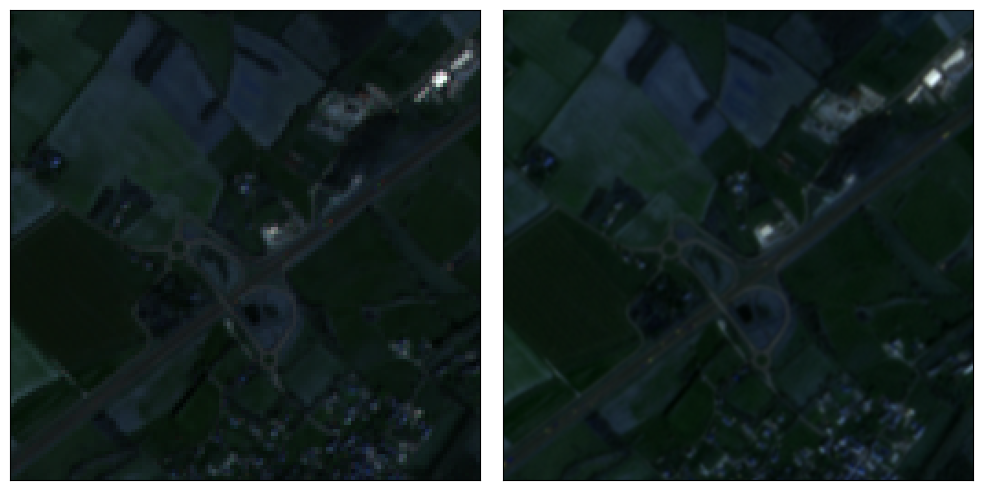

In [15]:
plot_gallery(
    [x_train[1].permute(1,2,0), y_train[1].permute(1,2,0)],
    xscale= 5,
    yscale=5
)

## SRCNN Architecture

In [16]:
class SRCNN(nn.Module):
    def __init__(self,f1=9,n1=64,f2=1,n2=32,f3=5,c=3):
        super().__init__()

        # paddings are chosen so that outputs remain the same size
        p1 = (f1 - 1)//2 
        p2 = (f2 - 1)//2
        p3 = (f3 - 1)//2
        self.upscale = nn.Sequential(nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False),
                                     nn.Conv2d(c, n1, f1,padding=p1),
                                     nn.ReLU(),
                                     nn.Conv2d(n1,n2,f2,padding=p2),
                                     nn.ReLU(),
                                     nn.Conv2d(n2,c,f3,padding=p3),
                                     )
    def forward(self,x):
        return self.upscale(x)
    
def output_size(N,F,P=0,D=1,S=1):
    return (N + 2*P - D*(F-1)-1)//S + 1

In [21]:
class TruncatedVGG16(nn.Module):
    """
    A truncated VGG19 network, such that its output is the
    'feature map obtained by the j-th convolution (after activation)
    before the i-th maxpooling layer within the VGG16 network', as defined in the paper.

    Used to calculate the MSE loss in this VGG feature-space, i.e. the VGG loss.
    """

    def __init__(self, i: int = 5, j: int = 4):
        """
        Parameters:
            i: the index i in the definition above
            j: the index j in the definition above
        """
        super().__init__()

        # Load the pre-trained VGG16 available in torchvision
        vgg16 = models.vgg16(weights="DEFAULT")

        maxpool_counter = 0
        conv_counter = 0
        truncate_at = 0
        # Iterate through the convolutional section ("features") of the VGG16
        for layer in vgg16.features.children():
            truncate_at += 1

            # Count the number of maxpool layers and the convolutional layers after each maxpool
            if isinstance(layer, nn.Conv2d):
                conv_counter += 1
            if isinstance(layer, nn.MaxPool2d):
                maxpool_counter += 1
                conv_counter = 0

            # Break if we reach the jth convolution after the (i - 1)th maxpool
            if maxpool_counter == i - 1 and conv_counter == j:
                break

        # Check if conditions were satisfied
        assert (
            maxpool_counter == i - 1 and conv_counter == j
        ), f"One or both of i={i} and j={j} are not valid choices for the VGG16!"

        # Truncate to the jth convolution (+ activation) before the ith maxpool layer
        self.truncated_vgg16 = nn.Sequential(
            *list(vgg16.features.children())[: truncate_at + 1]
        )
    
    def forward(self, x: torch.Tensor):
        """
        Parameters:
            input: high-resolution or super-resolution images, a tensor of size
                (N, 3, w * scaling factor, h * scaling factor)

        Returns
            (torch.Tensor): the specified VGG19 feature map, a tensor of size
                (N, feature_map_channels, feature_map_w, feature_map_h)
        """
        # (N, feature_map_channels, feature_map_w, feature_map_h)
        output = self.truncated_vgg16(x)

        return output

In [41]:
for layer in vgg16.features.children():
    print(layer)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

## Training

In [3]:
import torch.optim as optim
# from torch.utils.data import DataLoader
import tqdm
from torch.utils.data import DataLoader, Dataset
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

class DatasetWrapper(Dataset):
    def __init__(self, X, y=None):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        else:
            return self.X[idx], self.y[idx]

In [22]:
should_pin_memory = {"cuda": True, "cpu": False}

def train(model, x: torch.tensor, y: torch.tensor, lossfunc = nn.MSELoss(), 
          batch_size = 8, nepochs = 10, lr = 10e-4):
    
    losses = []
    epoch_losses = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # training loop
    dataloader = DataLoader(DatasetWrapper(x,y),
                              shuffle=True,  # Always set to true for training
                              batch_size=batch_size,  # Always try to set as powers of 2
                              drop_last=True  # Ensures batch size is always the one given (Drops last if its is smaller)
                                 # Faster push to GPU 
                              )
    
    vgg = TruncatedVGG16().to(device)
    vgg = vgg.eval()
    vgg = vgg.requires_grad_(False)

    loop = tqdm(range(nepochs), ncols=110)
    for i in loop: # for each epoch
        t0 = time()
        
        epoch_loss = 0
        n_batches = 0 
        for (x_batch, y_batch) in dataloader: # for each mini-batch
            n_batches += 1
            optimizer.zero_grad()

            # Move mini-batch data to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            out = model.forward(x_batch)
            

            for _ in x:
                vgg = TruncatedVGG16(1,2).to(device)
                vgg = vgg.eval()
                vgg = vgg.requires_grad_(False)

                y_batch_features = vgg.forward(y_batch)
                out_features = vgg.forward(out)
        
            loss = lossfunc(y_batch_features, out_features)
            epoch_loss += loss.item()
            losses.append(loss.item())

            # gradient descent 
            loss.backward()
            optimizer.step()

            # clear GPU
            torch.cuda.empty_cache()
        
        epoch_losses.append(epoch_loss)  
        epoch_loss /= n_batches
        loop.set_postfix(loss="%5.5f" % (epoch_loss)) 

    return losses, epoch_losses

def test(model, x: torch.tensor, y: torch.tensor, batch_size = 64, lossfunc = nn.MSELoss()):
    with torch.no_grad():# disable automatic gradient computation for efficiency
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        loss = 0
        n_batches = 0
        
        dataloader = DataLoader(DatasetWrapper(x,y),
                                shuffle=False,  # Always set to true for training
                                batch_size=batch_size,  # Always try to set as powers of 2
                                drop_last=True  # Ensures batch size is always the one given (Drops last if its is smaller) 
                              )
        
        for x_batch, y_batch in dataloader:
            n_batches += 1
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model.forward(x_batch)
            loss += lossfunc(out, y_batch)
    
        return (1/n_batches)*loss
    

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = TruncatedVGG16(i=1,j=2).to(device)
vgg = vgg.eval()
vgg = vgg.requires_grad_(False)

In [12]:
torch.manual_seed(1)
model = SRCNN(f2=3)
torch.cuda.empty_cache()
losses, epoch_losses = train(model, x_train, y_train, nepochs=100, batch_size = 16)

  0%|                                                                                 | 0/100 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 

In [13]:
torch.save(model,"C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/model.pt")

In [13]:
model = torch.load("C:/Users/skouf/Documents/2024/STAT3007/stat3007-project/SRCNN/saved/model.pt")

In [14]:
print(f"Train set accuracy: {test(model, x_train, y_train):.4f}")
print(f"Test set accuracy: {test(model, x_test, y_test):.4f}")

Train set accuracy: 0.0024
Test set accuracy: 0.0025


## Plotting predictions 

c:\Users\skouf\Documents\2024\STAT3007\stat3007-project\myenv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


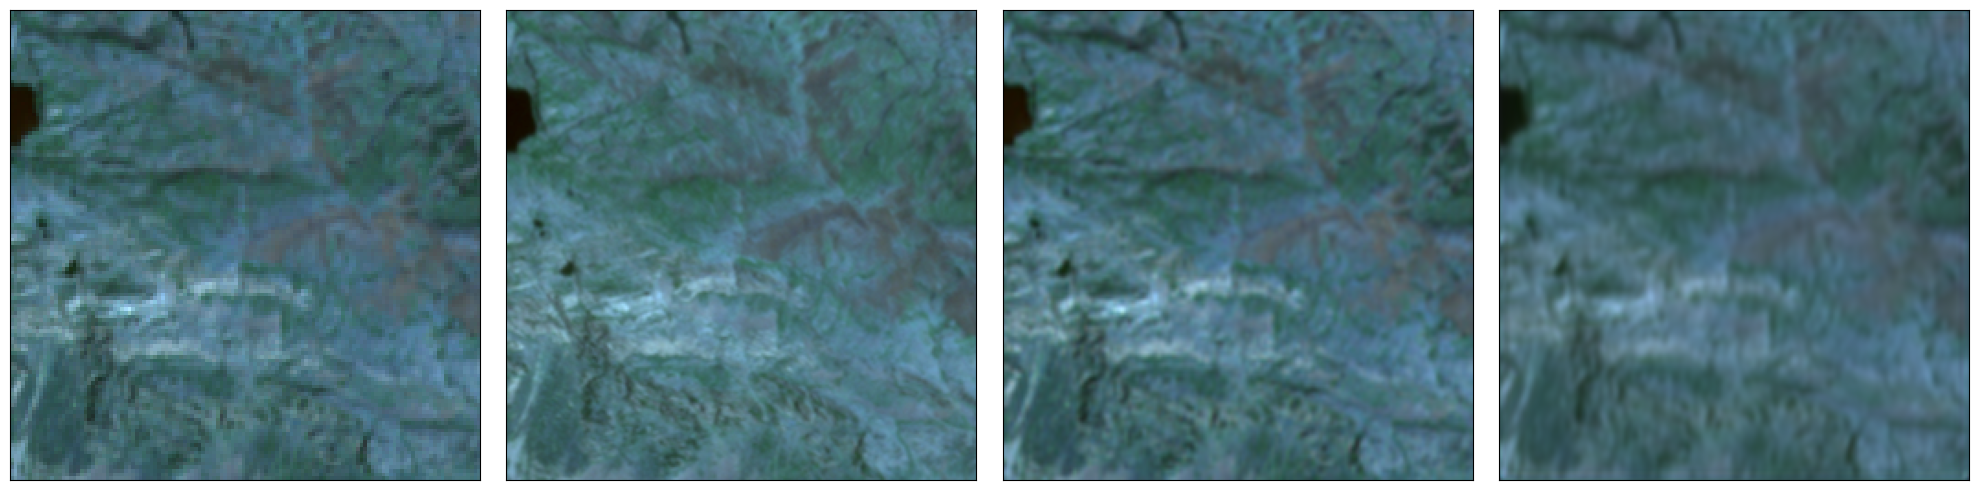

In [15]:
i = 6

out = model.forward(x_test[0:10].to(torch.device("cuda")))
o = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)(x_test[0:10])

plot_gallery(
    [x_test[i].permute(1,2,0),
    y_test[i].permute(1,2,0),
    o[i].permute(1,2,0), 
    out[i].cpu().detach().permute(1,2,0)],
    xscale=5,
    yscale=5
)